#  Семинар 11. Адаптивный дизайн эксперимента и суррогатное моделирование

## План семинара:

  * 0. Виды дизайна эксперимента. Факториальные дизайны.
  * 1. Методы заполнения для рандомизированных дизайнов эксперимента;
  * 2. Работа в библиотеке Surrogate Optimization Toolbox (pySOT) `pySOT`:
  https://pysot.readthedocs.io/en/latest/tutorials.html#tutorial-4-python-objective-function-with-inequality-constraints
  * 3*.Визуализация семплирования на 3-х мерных функциях;

Выделяют три вида дизайнов эксперимента:
    
* Screening (Factorial) - Для выявления наиболее важных факторов ( нализ категориальных признаков).
* Response Surface - Для анализа сигналов или процессов (напр. моделирование временных процессов)
* Mixture - Смешанный случай (напр. лекарственная формация)

## 0. Факториальный дизайн эксперимента

## Рассмотрим 2 простых примера:
1. Оптимально сваренный кофе: 
    
   Пример взят из: https://www.statease.com/publications/newsletter/stat-teaser-09-16#article1
    
   Мы хотим понять вклад каждого фактора и уменьшить количество экспериментов (c $2^5=32$ до $24$): 
   
   * Amount of Coffee (2.5 to 4.0 oz.)
   * Grind size (8-10mm)
   * Brew time (3.5 to 4.5 minutes)
   * Grind Type (burr vs blade)
   * Coffee beans (light vs dark)

Итоговая оценка дается в баллах(1-9)

In [1]:
import dexpy.factorial
import dexpy.power
import pandas as pd
import numpy as np
import patsy
import statsmodels.formula.api

In [2]:
# строим матрицу дизайна эксперимента по факторам
coffee_design = dexpy.factorial.build_factorial(5, 2**(5))
coffee_design.head()

,X1,X2,X3,X4,X5
0,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,1
2,-1,-1,-1,1,-1
3,-1,-1,-1,1,1
4,-1,-1,1,-1,-1


Исследовалась полная факториальная матрица, то есть 32 комбинации. 
К которым добавили 4 прохода по центральным значениям, для повешения точности прогноза. 

http://www.stat.purdue.edu/~zhanghao/STAT514/handout/chapter03/PowerSampleSize.pdf

https://stats.stackexchange.com/questions/80048/calculating-power-function-for-anova

https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C

https://en.wikipedia.org/wiki/F-distribution

https://en.wikipedia.org/wiki/F-test

In [3]:
column_names = ['amount', 'grind_size', 'brew_time', 'grind_type', 'beans']
coffee_design.columns = column_names
center_points = [
    [0, 0, 0, -1, -1],
    [0, 0, 0, -1,  1],
    [0, 0, 0,  1, -1],
    [0, 0, 0,  1,  1]
]

cp_df = pd.DataFrame(center_points * 2, columns=coffee_design.columns)
coffee_design = coffee_design.append(cp_df)
coffee_design.index = np.arange(0, len(coffee_design))

sn = 3.0
alpha = 0.1
model = ' + '.join(coffee_design.columns)
print('Модель:{}'.format(model))
factorial_power = dexpy.power.f_power(model, coffee_design, sn, alpha)
factorial_power.pop(0) 

# convert to %
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power]
factorial_power = pd.DataFrame(factorial_power,
                               columns=['Power'],
                               index=coffee_design.columns)
print("\nPower for full factorial:")
print(factorial_power)

Модель:amount + grind_size + brew_time + grind_type + beans

Power for full factorial:
              Power
amount      100.00%
grind_size  100.00%
brew_time   100.00%
grind_type  100.00%
beans       100.00%


Что будет, если мы уменьшим количество комбинаций до $ 2^4=16$  

In [4]:
# а теперь посчитаем для 
coffee_design = dexpy.factorial.build_factorial(5, 2**(5-1))
coffee_design.columns = column_names
center_points = [
    [0, 0, 0, -1, -1],
    [0, 0, 0, -1, 1],
    [0, 0, 0, 1, -1],
    [0, 0, 0, 1, 1]
]

coffee_design = coffee_design.append(pd.DataFrame(center_points * 2, columns=coffee_design.columns))
coffee_design.index = np.arange(0, len(coffee_design))

model = ' + '.join(coffee_design.columns)
factorial_power = dexpy.power.f_power(model, coffee_design, sn, alpha)
factorial_power.pop(0) 
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power] # перевод в %
factorial_power = pd.DataFrame(factorial_power,
                               columns=['Power'],
                               index=coffee_design.columns)

print("\nPower for fractional factorial:")
print(factorial_power)


Power for fractional factorial:
              Power
amount      100.00%
grind_size  100.00%
brew_time   100.00%
grind_type  100.00%
beans       100.00%


In [5]:
coffee_design.head()

,amount,grind_size,brew_time,grind_type,beans
0,-1,-1,-1,-1,1
1,-1,-1,-1,1,-1
2,-1,-1,1,-1,-1
3,-1,-1,1,1,1
4,-1,1,-1,-1,-1


In [6]:
twofi_model = "(" + '+'.join(coffee_design.columns) + ")**2"
desc = patsy.ModelDesc.from_formula(twofi_model)
factorial_power = dexpy.power.f_power(twofi_model, coffee_design, sn, alpha)
factorial_power.pop(0) # remove intercept
factorial_power = ['{0:.2f}%'.format(i*100) for i in factorial_power] # convert to %
factorial_power = pd.DataFrame(factorial_power,
                               columns=['Power'],
                               index=desc.describe().strip("~ ").split(" + "))

print("\nPower for fractional factorial (2FI model):")
print(factorial_power)

# захардкоженные результаты эксперимента
coffee_design['taste_rating'] = [
    4.4, 5.8, 6.8, 4.6, 2.6, 5, 6.2, 3.4,
    5.6, 5, 5.8, 6.6, 6.2, 3.4, 5, 6.4,
    6, 6, 6.8, 6, 6, 6.2, 5, 6.4
]

# Построим регрессиионный анализ МНК на данных
lm = statsmodels.formula.api.ols("taste_rating ~" + twofi_model, data=coffee_design).fit()
print(lm.summary2())

reduced_model = "amount + grind_size + brew_time + beans + grind_size:beans"
lm = statsmodels.formula.api.ols("taste_rating ~" + reduced_model, data=coffee_design).fit()
print(lm.summary2())


Power for fractional factorial (2FI model):
                         Power
amount                  99.99%
grind_size              99.99%
brew_time               99.99%
grind_type             100.00%
beans                  100.00%
amount:grind_size       99.99%
amount:brew_time        99.99%
amount:grind_type       99.99%
amount:beans            99.99%
grind_size:brew_time    99.99%
grind_size:grind_type   99.99%
grind_size:beans        99.99%
brew_time:grind_type    99.99%
brew_time:beans         99.99%
grind_type:beans       100.00%
                  Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.393  
Dependent Variable:   taste_rating      AIC:                 67.3916
Date:                 2018-11-30 14:47  BIC:                 86.2404
No. Observations:     24                Log-Likelihood:      -17.696
Df Model:             15                F-statistic:         1.994  
Df Residuals:         8                 Prob (F-statistic):  0.1

In [7]:
# Теперь отбираетм признаки по p-value и теперь мы знаем, наиболее важные факторы для идеального кофе.
# Профит.
pvalues = lm.pvalues[1:]
reduced_model = '+'.join(pvalues.loc[pvalues < 0.05].index)
lm = statsmodels.formula.api.ols("taste_rating ~" + reduced_model, data=coffee_design).fit()
print(lm.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.578   
Dependent Variable: taste_rating     AIC:                56.6842 
Date:               2018-11-30 14:47 BIC:                61.3964 
No. Observations:   24               Log-Likelihood:     -24.342 
Df Model:           3                F-statistic:        11.49   
Df Residuals:       20               Prob (F-statistic): 0.000135
R-squared:          0.633            Scale:              0.53417 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          5.4667   0.1492 36.6429 0.0000  5.1555  5.7779
grind_size        -0.4000   0.1827 -2.1892 0.0406 -0.7811 -0.0189
brew_time          0.4250   0.1827  2.3260 0.0306  0.0439  0.8061
grind_size:beans   0.9000   0.1827  4.9257 0.0001  0.5189  1.2811
---------------------------

2. Планирование химического эксперимента:
    
    Для наглядности в рассматриваем примере всего 2: 

    Reaction time (40-50 minutes)
    Temperature (80-90 °C)
    
    И успех оценивается в процентах: Conversion (%)
    
    Оптимальный дизайн будет выбираться по критерию D-optimal https://www.itl.nist.gov/div898/handbook/pri/section5/pri521.htm

In [8]:
import dexpy.optimal
from dexpy.model import make_model, ModelOrder
from dexpy.design import coded_to_actual
from patsy import dmatrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

reaction_design = dexpy.optimal.build_optimal(2, order=ModelOrder.quadratic)

column_names = ['time', 'temp']
actual_lows = { 'time': 40, 'temp': 80 }
actual_highs = { 'time': 50, 'temp': 90 }

reaction_design.columns = column_names

print(coded_to_actual(reaction_design, actual_lows, actual_highs))


quad_model = make_model(reaction_design.columns, ModelOrder.quadratic)
X = dmatrix(quad_model, reaction_design)
XtX = np.dot(np.transpose(X), X)
d = np.linalg.det(XtX)

print("|(X'X)| for quadratic 2 factor optimal design: {}".format(d))

fg = sns.lmplot('time', 'temp', data=reaction_design, fit_reg=False)
ax = fg.axes[0, 0]
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['40 min', '45 min', '50 min'])
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels(['80C', '85C', '90C'])
plt.show()

reaction_design = dexpy.optimal.build_optimal(2, run_count=10, order=ModelOrder.quadratic)
reaction_design.columns = column_names
print(coded_to_actual(reaction_design, actual_lows, actual_highs))

X = dmatrix(quad_model, reaction_design)
XtX = np.dot(np.transpose(X), X)
d = np.linalg.det(XtX)

print("|(X'X)| for quadratic 2 factor optimal design with 10 runs: {}".format(d))

fg = sns.lmplot('time', 'temp', data=reaction_design, fit_reg=False)
ax = fg.axes[0, 0]
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['40 min', '45 min', '50 min'])
ax.set_yticks([-1, 0, 1])
ax.set_yticklabels(['80C', '85C', '90C'])
plt.show()

reaction_design = dexpy.optimal.build_optimal(2, run_count=10, order=ModelOrder.quadratic)

        time       temp
0  40.000000  80.000000
1  50.000000  80.000000
2  50.000000  90.000000
3  40.000000  90.000000
4  45.454545  90.000000
5  50.000000  85.454545
|(X'X)| for quadratic 2 factor optimal design: 247.64152412234364


<Figure size 500x500 with 1 Axes>

        time       temp
0  40.000000  90.000000
1  40.000000  85.454545
2  50.000000  90.000000
3  50.000000  80.000000
4  40.000000  80.000000
5  45.454545  90.000000
6  44.545455  84.545455
7  40.000000  80.000000
8  45.454545  80.000000
9  50.000000  85.454545
|(X'X)| for quadratic 2 factor optimal design with 10 runs: 9364.269673034712


<Figure size 500x500 with 1 Axes>

In [9]:
# И мы получаем оптимизарованный дизайн эксперимента. Профит.
reaction_design

,X1,X2
0,-1.000000,1.000000
1,-1.000000,-0.090909
2,-1.000000,1.000000
3,0.090909,1.000000
4,-1.000000,-1.000000
5,1.000000,-0.090909
6,1.000000,-1.000000
7,1.000000,1.000000
8,0.090909,-1.000000
9,-0.090909,0.090909


## 1.Методы заполнения для рандомизированных дизайнов эксперимента

1.1. Latin Hypercube

In [10]:
import numpy as np
def latin_hypercube_2d_uniform(n, seed=None):
    np.random.seed(seed)
    lower_limits = np.arange(0, n)/n
    upper_limits = np.arange(1, n+1)/n
    
    points = np.random.uniform(low=lower_limits, high=upper_limits, size=(2, n)).T
    np.random.shuffle(points[:,1])
    
    return (points)

In [11]:
n = 10
p = latin_hypercube_2d_uniform(n, seed=137)

In [12]:
p

array([[0.09438502, 0.27579829],
       [0.1088544 , 0.96418556],
       [0.2695371 , 0.81089165],
       [0.36999904, 0.75104971],
       [0.44996003, 0.370125  ],
       [0.5502703 , 0.17644234],
       [0.68918032, 0.68621668],
       [0.70889536, 0.09978138],
       [0.88474964, 0.47656146],
       [0.93563409, 0.50054966]])

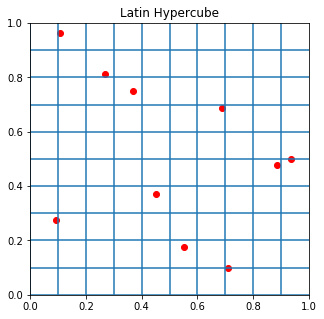

In [13]:
plt.figure(figsize=[5,5])
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(p[:,0],p[:,1], c='r')

for i in np.arange(0,1,1/n):
    plt.axvline(i)
    plt.axhline(i)
plt.grid(which='minor', alpha=0.9, linestyle='--')
plt.title('Latin Hypercube')   
plt.show()

#### Или же ядра можно построить в библиотеке 'pyDoE'
https://pythonhosted.org/pyDOE/rsm.html#response-surface

!['Custumize sample distribution'](https://pythonhosted.org/pyDOE/_images/lhs_custom_distribution.png)

In [14]:
#  Теперь предположим, что мы хотим, чтобы эти точки
#  были нормально распределены со средними = [0.5, 0.5] и стандартными отклонениями = [0.4, 0.2]:
from pyDOE import *
design = lhs(2, samples=10)
from scipy.stats.distributions import norm
means = [0.5, 0.5]
stdvs = [0.4, 0.2]
for i in range(2):
    design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])

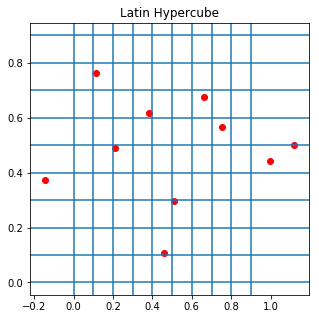

In [15]:
plt.figure(figsize=[5, 5])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

plt.scatter(design[:,0], design[:,1], c='r')

for i in np.arange(0, 1, 1 / n):
    plt.axvline(i)
    plt.axhline(i)

plt.grid(which='minor', alpha=0.9, linestyle='--')
plt.title('Latin Hypercube')   
plt.show()

#### А что, если мы не будем планировать эксперимент? 

В случае, если повтор эксперимента не затруднительный то нам на помощь приходят методы Монте-Карло.

Посмотрим на пример: Approximation of Pi Using Hit and Miss (Monte Carlo) Method 

Pi: 3.141592653589793, Аппроксимация: 3.16 
Pi: 3.141592653589793, Аппроксимация: 3.104 
Pi: 3.141592653589793, Аппроксимация: 3.1496 
Pi: 3.141592653589793, Аппроксимация: 3.13148 
Pi: 3.141592653589793, Аппроксимация: 3.141536 


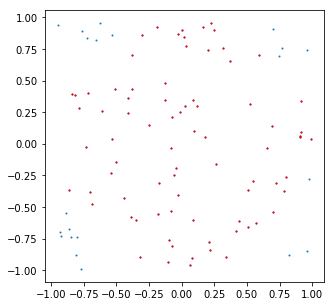

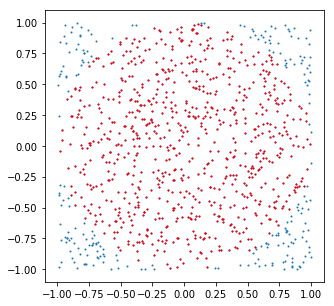

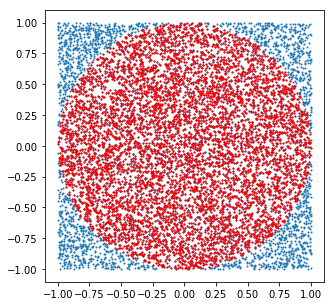

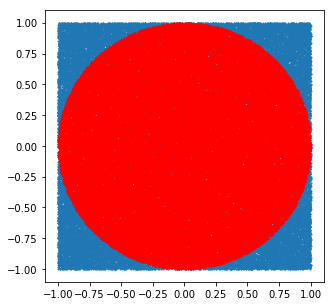

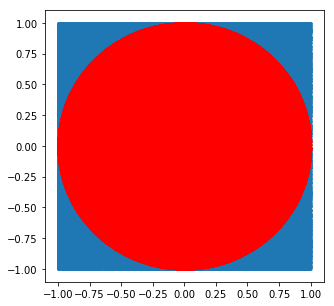

In [16]:
# Простой пример на оценку np.pi
N = [100, 1000, 10000, 100000, 1000000]

for i in range(len(N)):
    x = np.random.uniform(low= -1, high= 1, size = [N[i], 1])
    y = np.random.uniform(low= -1, high= 1, size = [N[i], 1])

    inside_bool = x**2 +y**2<1

    approx_pi = 4 * np.sum(inside_bool)/N[i]
    print ('Pi: {}, Аппроксимация: {} '.format(np.pi, approx_pi))
    
    x_in=x[inside_bool]
    y_in=y[inside_bool]
    
    plt.figure(figsize=[5,5])
    plt.scatter(x, y, s=1)
    plt.scatter(x_in, y_in, color ='r', s=1)

plt.show()

## 2. Работа в библиотеке Surrogate Optimization Toolbox (pySOT) `pySOT`

#### Наша задача здесь находить глобальные минимумы функции. Библиотека, которую мы используем часто применяется в для моделирования химических эскпериментов. В источниках внизу ноутбука есть лекция от автора библиотеки на эту тему.

Сам функционал рассчитан на моделирование процессов высокой размерности: 10 и более. 
Мы будем считать для трехмерного варианта.

Зададим функцию для дальнейшей аппроксимации (Ackley)
https://www.sfu.ca/~ssurjano/ackley.html

!['Ackley function'](https://www.sfu.ca/~ssurjano/ackley.png)

In [17]:
from pySOT import *
from poap.controller import SerialController, ThreadController, BasicWorkerThread
import numpy as np

# количество запусков
maxeval = 100

# (1) Проблема
# Есть готовая функция для Ackley, ей и воспользуемся - построим для 3D функции
data = Ackley(dim=3) 
print(data.info)

# (2) Дизайн
# Симметричные латинские гиперкубы с 2d + 1 сэмплов
exp_des = SymmetricLatinHypercube(dim=data.dim, npts=2*data.dim+1)

# (3) Суррогатная модель
# RBF-ядро с линейным хвостом
surrogate = RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval)

# (4) Adaptive sampling
#  DYCORS
adapt_samp = CandidateDYCORS(data=data, numcand=100*data.dim)

3-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


In [18]:
# Use the serial controller (uses only one thread)
controller = SerialController(data.objfunction)

# (5) Use the sychronous strategy without non-bound constraints
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=1,
        exp_design=exp_des, response_surface=surrogate,
        sampling_method=adapt_samp)
controller.strategy = strategy

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 0.018099024530908725
Best solution found: [ 0.00007 -0.00184  0.00718]


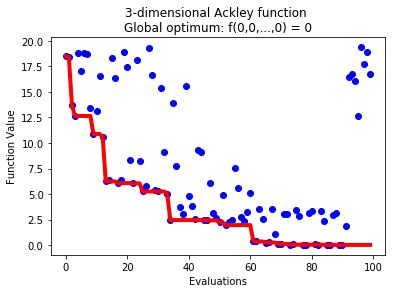

In [19]:
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

In [20]:
# Авторы предлагаю свою поточную оптимизацию процессов
# Use the threaded controller
controller = ThreadController()

# (5) Use the sychronous strategy without non-bound constraints
# Use 4 threads and allow for 4 simultaneous evaluations
nthreads = 4
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=nthreads,
        exp_design=exp_des, response_surface=surrogate,
        sampling_method=adapt_samp)
controller.strategy = strategy

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 0.013606910464336597
Best solution found: [ 0.      -0.00565  0.     ]


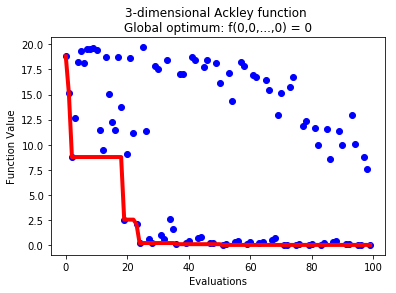

In [21]:
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

In [22]:
# Функция оптимизации
class SomeFun:
    def __init__(self, dim=10):
        self.xlow = -10 * np.ones(dim) # lower bounds
        self.xup = 10 * np.ones(dim) # upper bounds
        self.dim = dim # dimensionality
        self.info = "Our own " + str(dim)+"-dimensional function" # info
        self.integer = np.array([0]) # integer variables
        self.continuous = np.arange(1, dim) # continuous variables

    def objfunction(self, x):
        return np.sum(x) * np.cos(np.sum(x))

In [23]:
import numpy as np
from pySOT import check_opt_prob
data = SomeFun(dim=3)
check_opt_prob(data)

In [24]:
from pySOT import *
from poap.controller import SerialController, BasicWorkerThread

# Decide how many evaluations we are allowed to use
maxeval = 100

# (1) Optimization problem
data = Ackley(dim=3)
print(data.info)

# (2) Experimental design
# Use a symmetric Latin hypercube with 2d + 1 samples
exp_des = SymmetricLatinHypercube(dim=data.dim, npts=2*data.dim+1)

# (3) Surrogate model
# Use a cubic RBF interpolant with a linear tail
surrogate = RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval)

# (4) Adaptive sampling
# Use DYCORS with 100d candidate points
adapt_samp = CandidateDYCORS(data=data, numcand=100*data.dim)

3-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


In [25]:
# Оптимизируем вычисления
controller = SerialController(data.objfunction)

# (5) Use the sychronous strategy without non-bound constraints
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=1,
        exp_design=exp_des, response_surface=surrogate,
        sampling_method=adapt_samp)
controller.strategy = strategy

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 0.005170989532729653
Best solution found: [ 0.00135  0.00128 -0.00117]


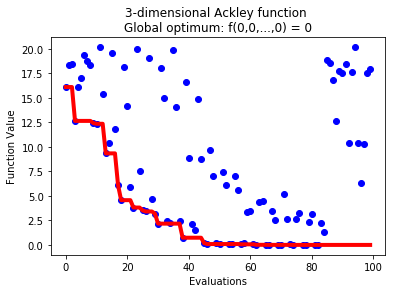

In [26]:
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

Таким образом, последняя оценка со введением внутренней оптимизации у нас получилась точнее всего

- Best value found: 0.007130161064833107
- Best solution found: [ 0.00296 -0.00049 -0.00036]

# 3*. Визуализация семплирования на 3-х мерных функциях;

Смотрим вторую часть ноутбука (Материалы школы DeepBayes) - тут построены 3D визуализации и анимации Randomized Designs по поверхностям. 

http://nbviewer.jupyter.org/github/siri3us/ASML/blob/master/notebooks/seminar_07_gpr_open.ipynb

## Gaussian graphical models with skggm

https://skggm.github.io/skggm/tour

In [27]:
%matplotlib inline
# Import from skggm
import inverse_covariance as ic
from inverse_covariance import (
    QuicGraphLasso,
    QuicGraphLassoCV,
    QuicGraphLassoEBIC,
    AdaptiveGraphLasso,
    ModelAverage
)
from inverse_covariance.plot_util import trace_plot
import networkx as nx
options_nx = {
    'node_size': 200,
    'linewidths': 0,
    'width': 0.4,
}

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [29]:
# Notebook wide settings
n_features = 15
adj_type = 'banded'

In [30]:
from simulate_networks import *

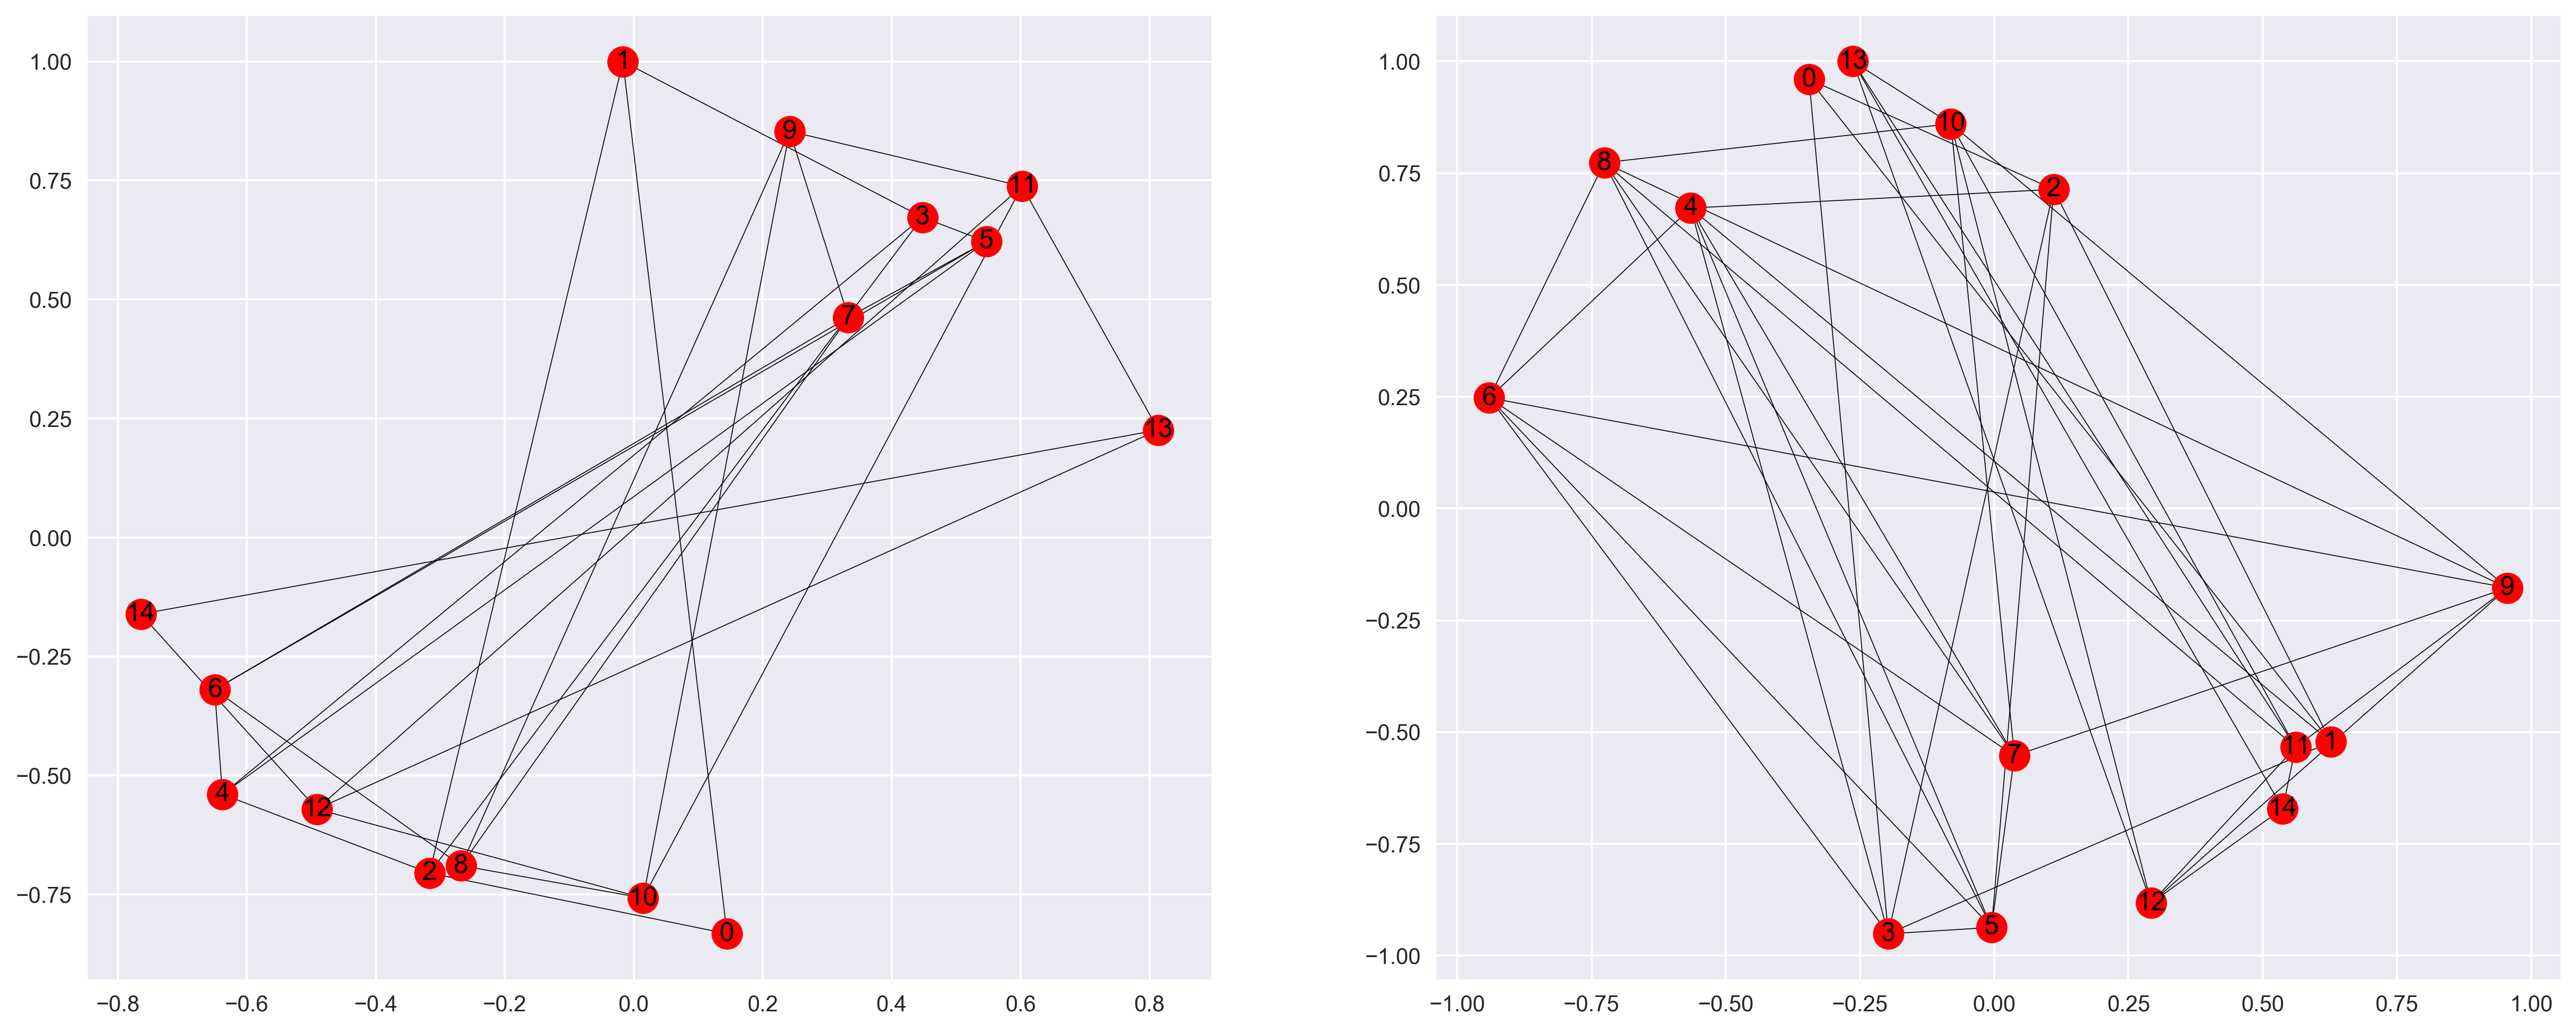

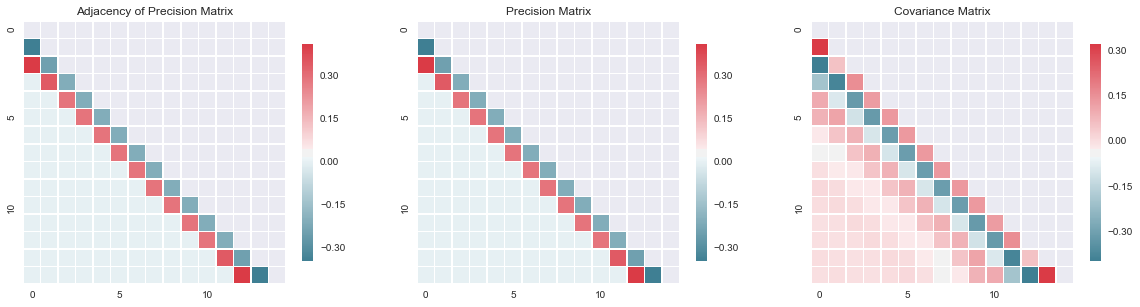

In [31]:
covariance, precision, adjacency = new_graph(15, .15, adj_type=adj_type, random_sign=True, seed=1)    
covariance2, precision2, adjacency2 = new_graph(15, .2, adj_type=adj_type, random_sign=True, seed=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8),dpi=300);
nx.draw_networkx(nx.from_numpy_matrix(adjacency), ax=ax1, **options_nx)
nx.draw_networkx(nx.from_numpy_matrix(adjacency2), ax=ax2, **options_nx)
plt.show()

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8));

compare_population_parameters(covariance, precision, adjacency, figures=(f, (ax1, ax2, ax3)))


### Example of Degeneracy in High Dimensions

Degree $=2$.

Degree $=3$.

At large sample sizes, their sample covariances are distinguishable and a simple inverse precision matrix captures the original structure.

At small sample sizes both sample covariances and their precision counterparts become indistinguishable.

Text(0.5,1,'Sample Precision Matrix, n/p=10')

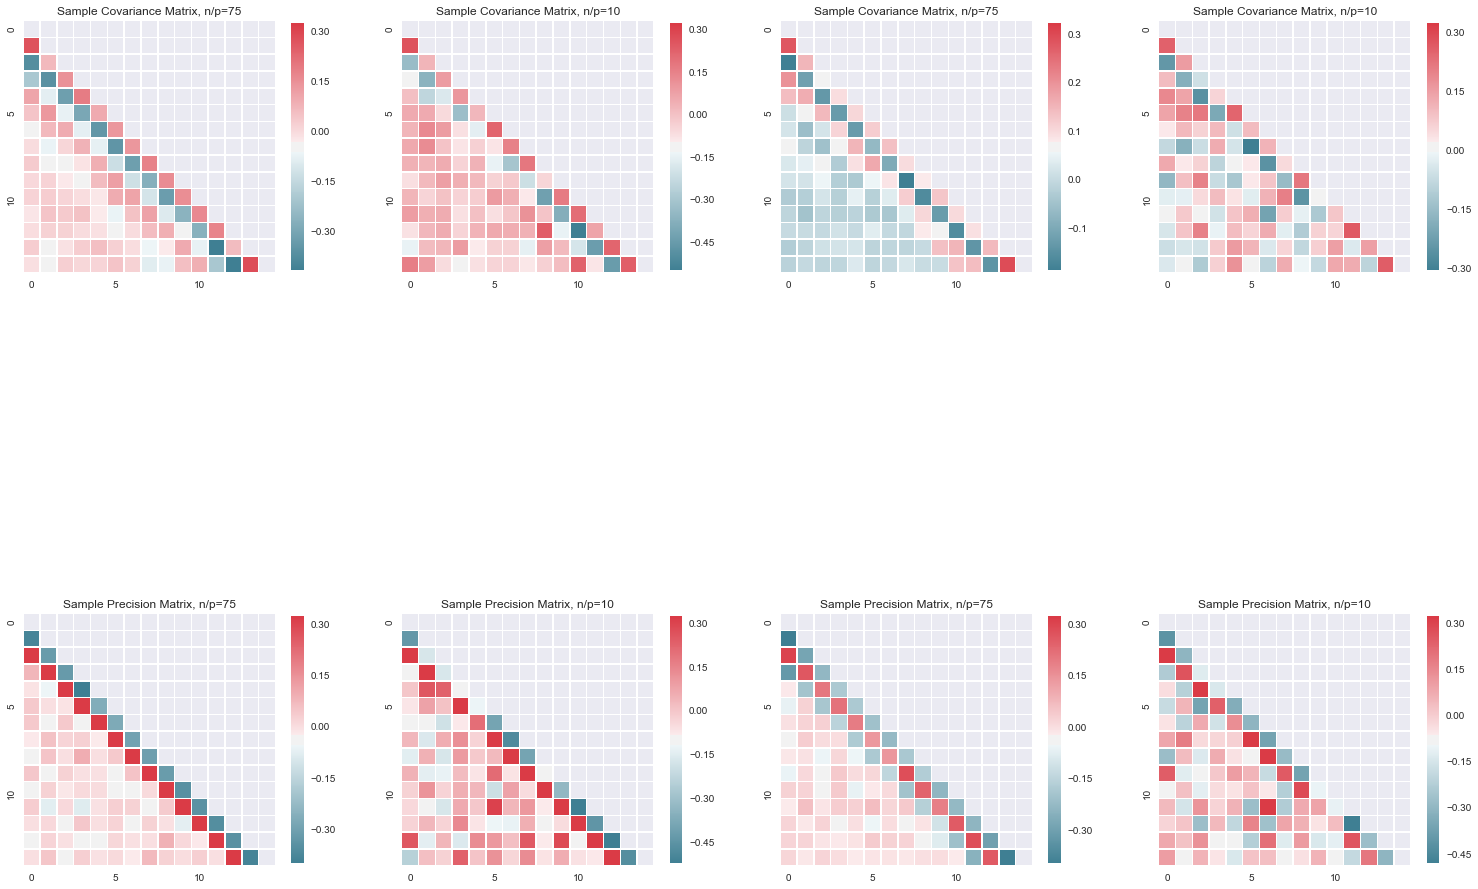

In [32]:
prng = np.random.RandomState(2)
X1 = mvn(75*n_features,n_features,covariance,random_state=prng)
X2 = mvn(10*n_features,n_features,covariance,random_state=prng)
X3 = mvn(75*n_features,n_features,covariance2,random_state=prng)
X4 = mvn(10*n_features,n_features,covariance2,random_state=prng)

mask = np.zeros_like(precision, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.where(np.eye(np.shape(precision)[0]))] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ([ax1, ax2, ax5, ax7], [ax3, ax4, ax6, ax8]) = plt.subplots(2, 4, figsize=(26, 20));
cov_vmax = np.max(np.triu(covariance,1))
sns.heatmap(np.tril(np.cov(X1,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Sample Covariance Matrix, n/p=75')
sns.heatmap(np.tril(np.cov(X2,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Sample Covariance Matrix, n/p=10')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X1,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Sample Precision Matrix, n/p=75')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X2,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax4)
ax4.set_title('Sample Precision Matrix, n/p=10')
sns.heatmap(np.tril(np.cov(X3,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax5)
ax5.set_title('Sample Covariance Matrix, n/p=75')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X3,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax6)
ax6.set_title('Sample Precision Matrix, n/p=75')
sns.heatmap(np.tril(np.cov(X4,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax7)
ax7.set_title('Sample Covariance Matrix, n/p=10')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X4,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax8)
ax8.set_title('Sample Precision Matrix, n/p=10')

### Part II. Sparse Inverse Covariance via Penalized MLE

/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLasso is deprecated; The class QuicGraphLasso is deprecated Use class QuicGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)


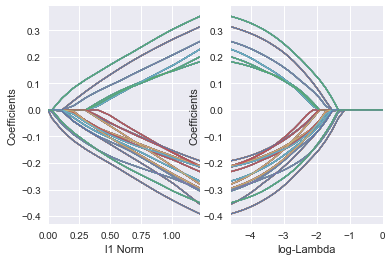

Press any key to continue.1


In [33]:
# show graphical lasso path 
covariance, precision, adjacency = new_graph(15,.2,adj_type=adj_type,random_sign=True,seed=1)    
prng = np.random.RandomState(2)

X = mvn(20 * n_features, n_features, covariance, random_state=prng)
path = np.logspace(np.log10(0.01), np.log10(1.0), num=25, endpoint=True)[::-1]
estimator = QuicGraphLasso(lam=1.0, path=path, mode='path')
estimator.fit(X)

trace_plot(estimator.precision_, estimator.path_)

###  Model Selection: Cross-Validation versus EBIC¶

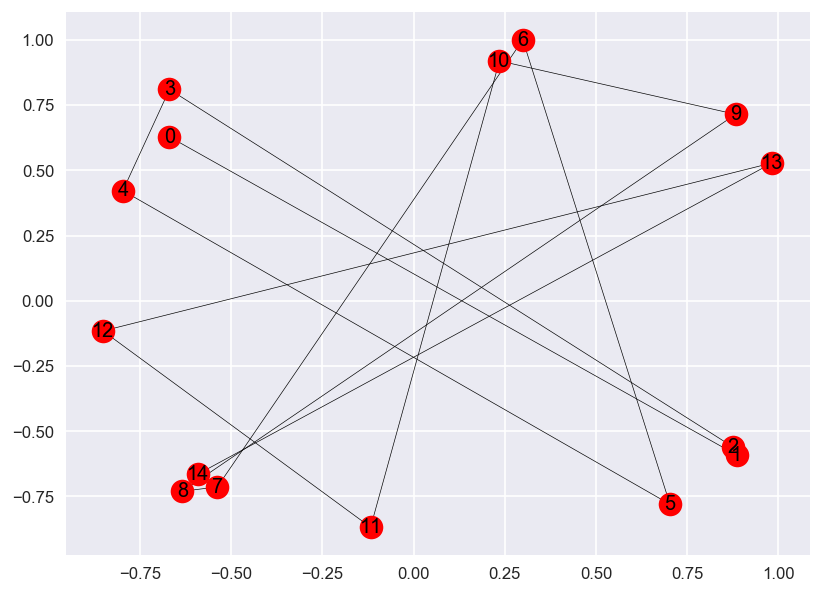

QuicGraphLassoCV with:
   metric: log_likelihood


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoCV is deprecated; The class QuicGraphLassoCV is deprecated Use class QuicGraphicalLassoCV instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/acappello/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/acappello/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


   len(cv_lams): 25
   lam_scale_: 1.2916232883014405
   lam_: 0.00928487084265348
QuicGraphLassoEBIC with:
   len(path lams): 100
   lam_scale_: 1.2916232883014405
   lam_: 0.07743519571985434


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoEBIC is deprecated; The class QuicGraphLassoEBIC is deprecated Use class QuicGraphicalLassoEBIC instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/acappello/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/acappello/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1965: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


In [34]:
metric='log_likelihood';
covariance, precision, adjacency = new_graph(n_features, .05, adj_type='banded', random_sign=True, seed=1) # BUG:Might fail with other graphs   

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6),dpi=120);
nx.draw_networkx(nx.from_numpy_matrix(adjacency), ax=ax1, **options_nx)
plt.show()


prng = np.random.RandomState(2)
X = mvn(10*n_features,n_features,covariance,random_state=prng)

print ('QuicGraphLassoCV with:')
print ('   metric: {}'.format(metric))
cv_model = QuicGraphLassoCV(
        cv=2, 
        n_refinements=6,
        n_jobs=1,
        init_method='cov',
        score_metric=metric)
cv_model.fit(X)
cv_precision_ = cv_model.precision_
print ('   len(cv_lams): {}'.format(len(cv_model.cv_lams_)))
print ('   lam_scale_: {}'.format(cv_model.lam_scale_))
print ('   lam_: {}'.format(cv_model.lam_))

# EBIC
gamma = .1 # gamma = 0 equivalent to BIC and gamma=.5 for ultra high dimensions
ebic_model = QuicGraphLassoEBIC(
    lam=1.0,
    init_method='cov',
    gamma = gamma)
ebic_model.fit(X)
ebic_precision_ = ebic_model.precision_
print ('QuicGraphLassoEBIC with:')
print ('   len(path lams): {}'.format(len(ebic_model.path_)))
print ('   lam_scale_: {}'.format(ebic_model.lam_scale_))
print ('   lam_: {}'.format(ebic_model.lam_))

Text(0.5,1,'Selected Precision, EBIC')

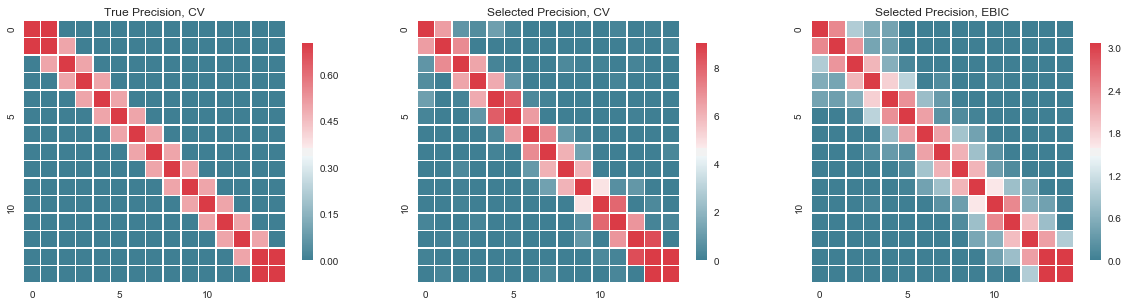

In [35]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 8));

mask = np.zeros_like(precision, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.where(np.eye(np.shape(precision)[0]))] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

prec_vmax = np.max(np.triu(np.abs(adjacency),1))
sns.heatmap(np.abs(adjacency),cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('True Precision, CV')

prec_vmax = np.max(np.triu(np.abs(cv_precision_),1))
sns.heatmap(np.abs(cv_precision_),cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Selected Precision, CV')

prec_vmax = np.max(np.triu(np.abs(ebic_precision_),1))
sns.heatmap(np.abs(ebic_precision_),cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Selected Precision, EBIC')

### Part III. Compare Estimators: Initial vs. Adaptive


#### Initial vs. Adaptive, High Sample Size

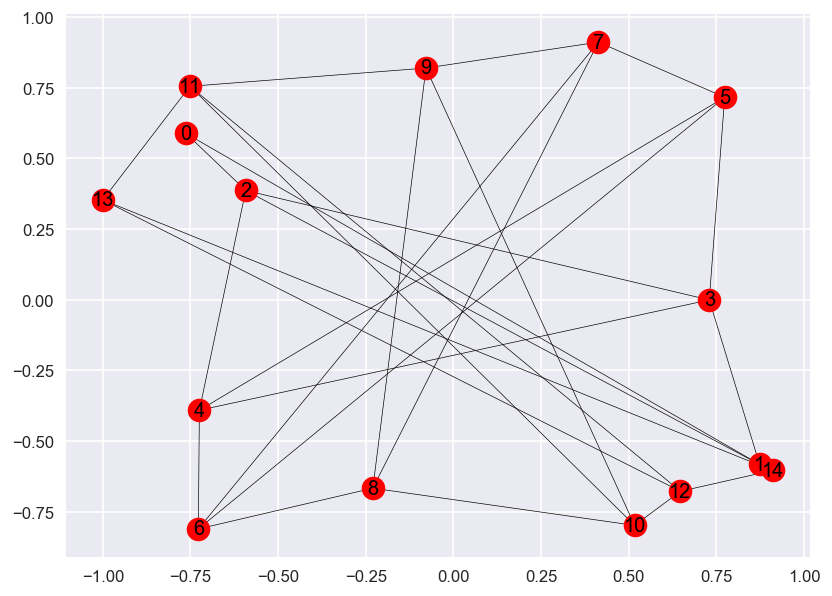

n = 1125, p = 15


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoCV is deprecated; The class QuicGraphLassoCV is deprecated Use class QuicGraphicalLassoCV instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 69,143
Frob Norm: 0.38637213154117817 (0.8119427064234496), Support Error: 37.0, False Pos: 37.0, False Neg: 0.0


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class AdaptiveGraphLasso is deprecated; The class AdaptiveGraphLasso is deprecated Use class AdaptiveGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 69,89
Frob Norm: 0.5392396286049491 (0.7900247089486948), Support Error: 10.0, False Pos: 10.0, False Neg: 0.0



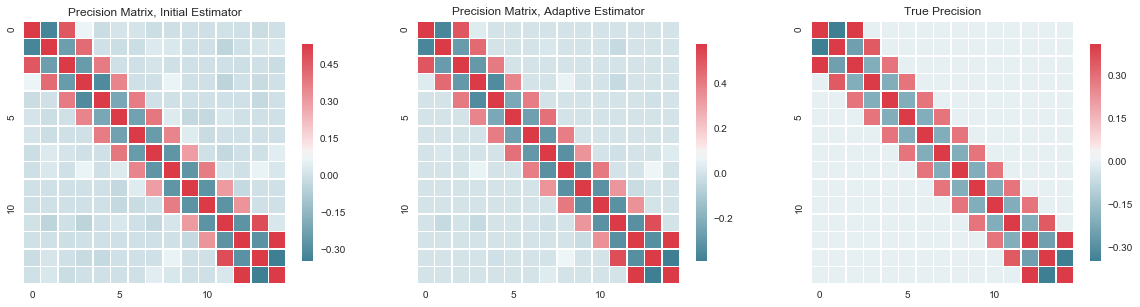

In [36]:
covariance, precision, adjacency = new_graph(15, .15, adj_type=adj_type, random_sign=True, seed=1)
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6),dpi=120);
nx.draw_networkx(nx.from_numpy_matrix(adjacency), ax=ax1, **options_nx)
plt.show()

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 8));

n_samples = 75*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

print ('n = {}, p = {}'.format(n_samples,n_features))

compare_init_adaptive(X,n_samples,n_features,covariance=covariance, 
                      precision=precision, adjacency=adjacency, figures=(f, (ax1,ax2,ax3)))

#### Initial vs. Adaptive, Low Sample Size

n = 225,p = 15


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoCV is deprecated; The class QuicGraphLassoCV is deprecated Use class QuicGraphicalLassoCV instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 69,149
Frob Norm: 0.5589090744859746 (0.8955488045009943), Support Error: 40.0, False Pos: 40.0, False Neg: 0.0


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class AdaptiveGraphLasso is deprecated; The class AdaptiveGraphLasso is deprecated Use class AdaptiveGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 69,105
Frob Norm: 0.6922447388699072 (1.060538714336359), Support Error: 18.0, False Pos: 18.0, False Neg: 0.0



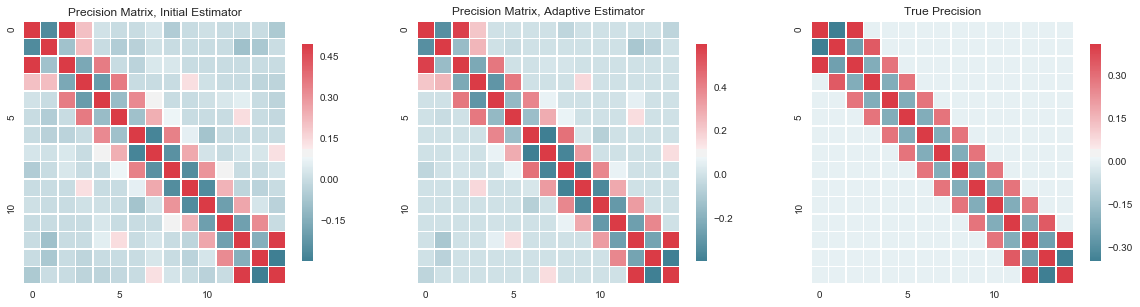

In [37]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 8));

n_samples = 15*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print ('n = {},p = {}'.format(n_samples, n_features))

compare_init_adaptive(X,n_samples,n_features,covariance=covariance, 
                      precision=precision, adjacency=adjacency, figures=(f, (ax1,ax2,ax3)))

#### Initial vs. Adaptive in Moderately Dense Graphs

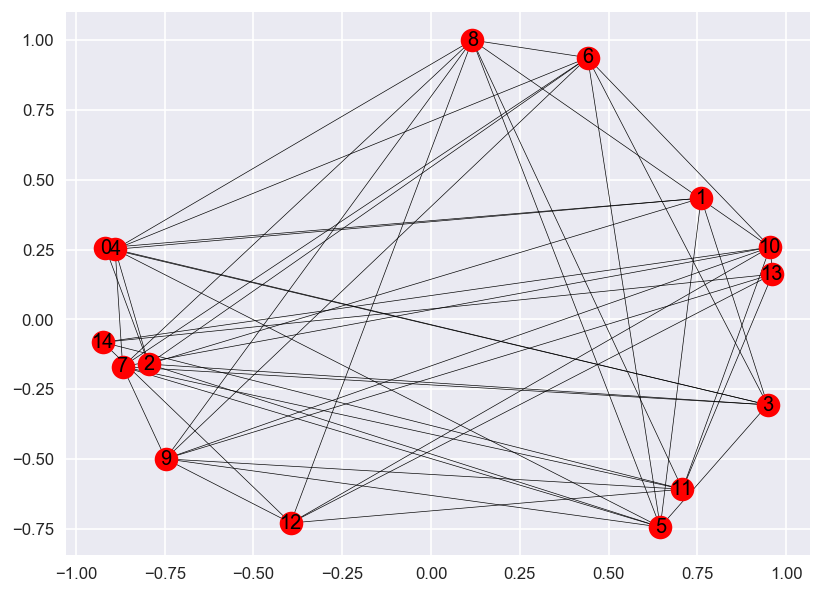

/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoCV is deprecated; The class QuicGraphLassoCV is deprecated Use class QuicGraphicalLassoCV instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 115,163
Frob Norm: 1.312439131064629 (2.5913976590989676), Support Error: 40.0, False Pos: 32.0, False Neg: 8.0


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class AdaptiveGraphLasso is deprecated; The class AdaptiveGraphLasso is deprecated Use class AdaptiveGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 115,109
Frob Norm: 1.5383079883191835 (2.641333520357878), Support Error: 27.0, False Pos: 12.0, False Neg: 15.0



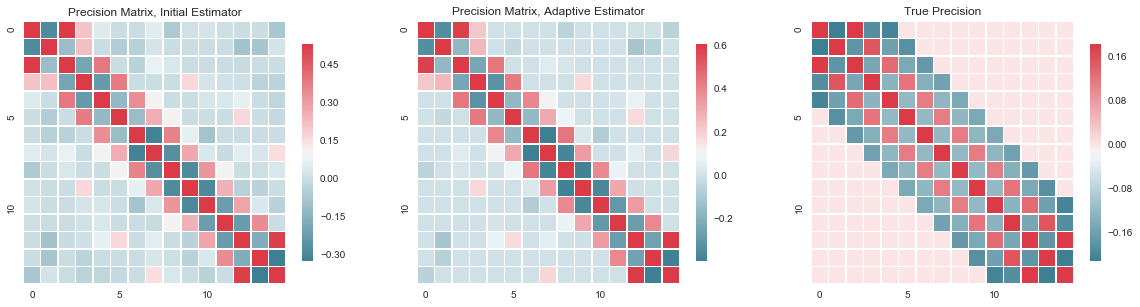

In [38]:
%matplotlib inline
covariance, precision, adjacency = new_graph(15,.4,adj_type=adj_type,random_sign=True,seed=1) 
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6),dpi=120);
nx.draw_networkx(nx.from_numpy_matrix(adjacency), ax=ax1, **options_nx)
plt.show()

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 8));
compare_init_adaptive(X,n_samples,n_features,covariance=covariance, 
                      precision=precision, adjacency=adjacency, figures=(f, (ax1,ax2,ax3)))

#### High Sample Size

n = 1125,p = 15


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoCV is deprecated; The class QuicGraphLassoCV is deprecated Use class QuicGraphicalLassoCV instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 115,163
Frob Norm: 0.30913062653087064 (0.5162856083085142), Support Error: 24.0, False Pos: 24.0, False Neg: 0.0


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class AdaptiveGraphLasso is deprecated; The class AdaptiveGraphLasso is deprecated Use class AdaptiveGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 115,143
Frob Norm: 0.3506533250399896 (0.5986663687373193), Support Error: 14.0, False Pos: 14.0, False Neg: 0.0



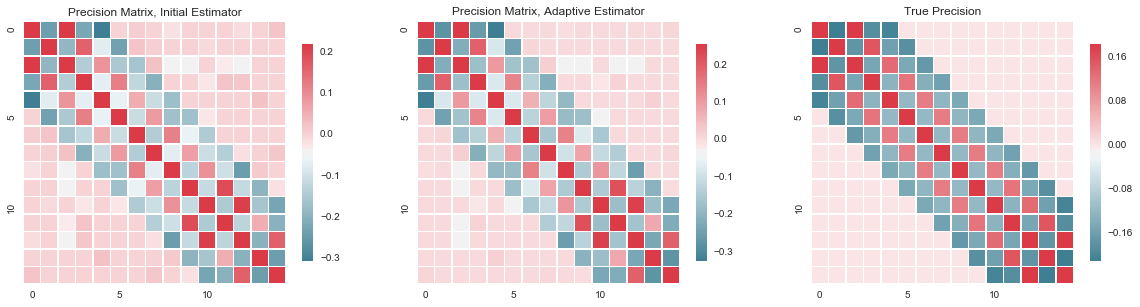

In [39]:
%matplotlib inline
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 8));

n_samples = 75*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print ('n = {},p = {}'.format(n_samples,n_features))

compare_init_adaptive(X,n_samples,n_features,covariance=covariance, 
                      precision=precision, adjacency=adjacency, figures=(f, (ax1,ax2,ax3)))

#### Low Sample Size

n = 300,p = 15


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class QuicGraphLassoCV is deprecated; The class QuicGraphLassoCV is deprecated Use class QuicGraphicalLassoCV instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 115,159
Frob Norm: 0.5557884766064537 (1.0696649359339576), Support Error: 28.0, False Pos: 25.0, False Neg: 3.0


/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class AdaptiveGraphLasso is deprecated; The class AdaptiveGraphLasso is deprecated Use class AdaptiveGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)


Difference in sparsity: 115,119
Frob Norm: 0.6870890554367179 (1.3409481264665861), Support Error: 16.0, False Pos: 9.0, False Neg: 7.0



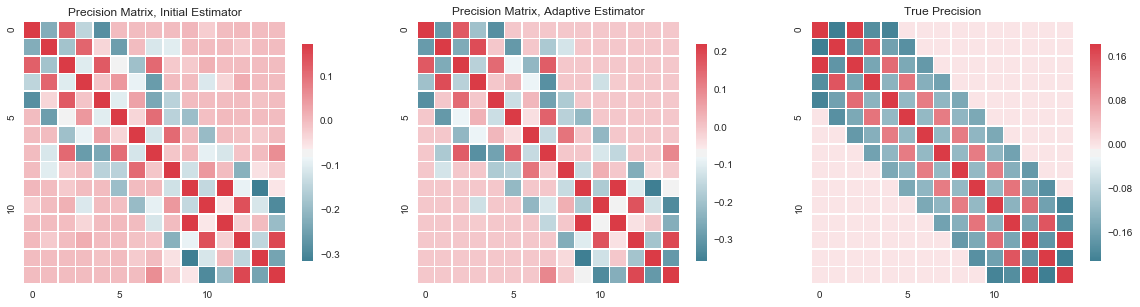

In [40]:
%matplotlib inline
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 8));

n_samples = 20*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print ('n = {},p = {}'.format(n_samples,n_features))

compare_init_adaptive(X,n_samples,n_features,covariance=covariance, 
                      precision=precision, adjacency=adjacency, figures=(f, (ax1,ax2,ax3)))

## Part IV Model Averaging

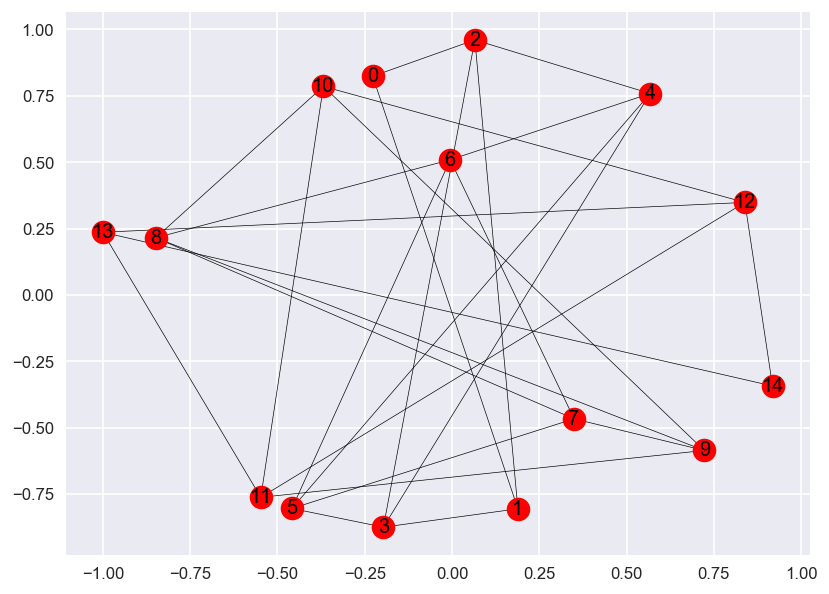

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


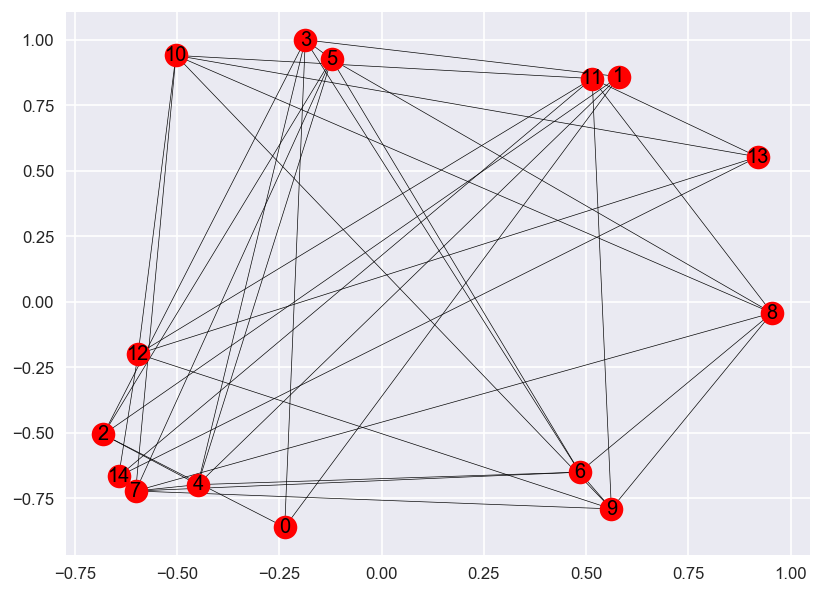

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


ModelAverage(bootstrap=<function _default_bootstrap at 0x7fd390210ea0>,
       estimator=None, init_method='corrcoef', lam=0.15, lam_perturb=0.5,
       n_jobs=1, n_trials=50, normalize=True, penalization='fully-random',
       penalty_name='lam', sc=None, seed=1, subsample=0.3,
       support_thresh=0.5)

In [41]:
covariance, precision, adjacency = new_graph(15, .15, adj_type=adj_type, random_sign=True, seed=1)
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6),dpi=120);
nx.draw_networkx(nx.from_numpy_matrix(adjacency), ax=ax1, **options_nx)
plt.show()
n_samples = 15 * n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

ensemble_estimator = ModelAverage(
            n_trials=50,
            penalization='fully-random',
            lam=0.15)
ensemble_estimator.fit(X)

covariance, precision, adjacency = new_graph(15, .3, adj_type=adj_type, random_sign=True, seed=1)   
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6),dpi=120);
nx.draw_networkx(nx.from_numpy_matrix(adjacency), ax=ax1, **options_nx)
plt.show()
n_samples = 15*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

ensemble_estimator2 = ModelAverage(
            n_trials=50,
            penalization='fully-random',
            lam=0.15)
ensemble_estimator2.fit(X)

In [42]:
from simulate_networks import _false_support

Difference in sparsity: 93,53
Support Error:, False Pos: 1.0, False Neg: 21.0
Difference in sparsity: 93,25
Support Error:, False Pos: 0.0, False Neg: 34.0


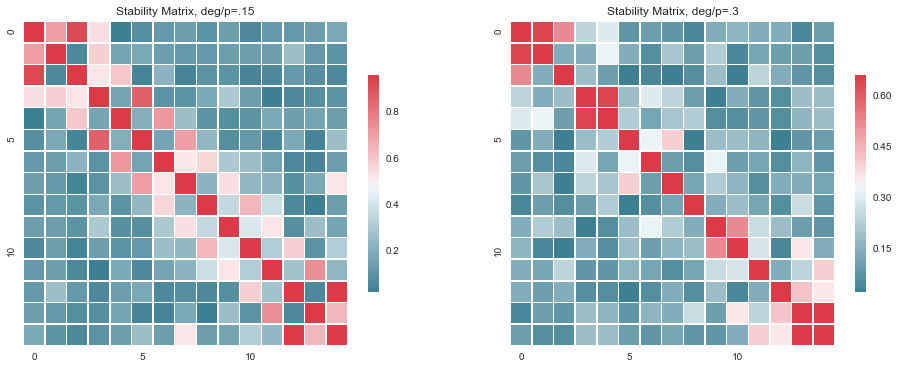

In [43]:
# Plot comparison
f, (ax2, ax3) = plt.subplots(1,2, figsize=(16, 8));

stability_threshold = .5
prec_hat = ensemble_estimator.proportion_
prec_vmax = np.max(np.triu(prec_hat,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(prec_hat,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Stability Matrix, deg/p=.15')
print ('Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(prec_hat>stability_threshold,0))
))
err_fp, err_fn = _false_support(precision,np.greater(ensemble_estimator.proportion_,stability_threshold))
print ('Support Error:, False Pos: {}, False Neg: {}'.format(
    err_fp,
    err_fn
))
 
prec_hat = ensemble_estimator2.proportion_
prec_vmax = np.max(np.triu(prec_hat,1))
sns.heatmap(prec_hat,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Stability Matrix, deg/p=.3')
print ('Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(prec_hat>stability_threshold,0))
))
err_fp, err_fn = _false_support(precision,np.greater(ensemble_estimator2.proportion_,stability_threshold))
print ('Support Error:, False Pos: {}, False Neg: {}'.format(
    err_fp,
    err_fn
))

### Список полезной литературы по теме :

* https://ipam.wistia.com/medias/cyg8faq730 (Видео по применению суррогатного моделирования в химии)
* Rommel G Regis and Christine A Shoemaker. A stochastic radial basis function method for the global optimization of expensive functions. INFORMS Journal on Computing, 19(4): 497–509, 2007.
* Rommel G Regis and Christine A Shoemaker. Parallel stochastic global optimization using radial basis functions. INFORMS Journal on Computing, 21(3):411–426, 2009.
* Rommel G Regis and Christine A Shoemaker. Combining radial basis function surrogates and dynamic coordinate search in high-dimensional expensive black-box optimization. Engineering Optimization, 45(5): 529–555, 2013.
* Juliane Muller and Robert Piche . Mixture surrogate models based on Dempster-Shafer theory for global optimization problems. Journal of Global Optimization, 51 (1):79–104, 2011.
* Juliane Muller, Christine A Shoemaker, and Robert Piche SO-MI: A surrogate model algorithm for computationally expensive nonlinear mixed-integer black-box global optimization problems. Computers & Operations Research, 40(5):1383– 1400, 2013.
* Juliane Muller, Christine A Shoemaker, and Robert Piche SO-I: a surrogate model algorithm for expensive nonlinear integer programming problems including global optimization applications. Journal of Global Optimization, 59(4):865–889, 2014.